# Corona and Airbnb in Berlin
## by Jan Henner

# Table of Contents
<ul>
<li><a href="#intro">Intro: Dataset & questions</a></li>
<li><a href="#wrangling">Data Wrangling</a></li>
    <ul><li><a href="#gather">Gather datasets</a></li></ul>
    <ul><li><a href="#assess_and_clean">Assess and clean</a></li></ul>
<li><a href="#eda">Analyze, Model, and Visualize</a></li>
    <ul><li><a href="#impact_demand">Corona impact on Airbnb demand</a></li></ul>
    <ul><li><a href="#host_reaction">Host Reaction</a></li></ul>
    <ul><li><a href="#happy">Happyness of Travelers</a></li></ul>
<li><a href="#conclusions">Conclusions</a></li>
</ul>

<a id='intro'></a>
# Introduction

## Dataset
The data comes from the Murray Cox Inside Airbnb project [insideAirbnb.com](http://insideAirbnb.com/). The "summary information and metrics" files are used, and additionally the "Detailed Review Data" for the sentiment analysis. The dates used are 08.06.2019 and 13.06.2020.


## Business Questions
How did the Coronavirus affect Airbnb's demand and supply in Berlin?

1. What is the Corona impact on Airbnb's demand in Berlin? (identified by days since last review)
2. How do the hosts react to the Corona virus? (identified by number of offers, price, and cancellation policy)
3. For those who travel in Corona times: how happy are they with the stay? (sentiment analysis on reviews)

<a id='wrangling'></a>

# Data Wrangling

<a id='gather'></a>
## Gather Data

In [1]:
# import all packages and set plots to be embedded inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
import warnings

import datetime
import nltk
nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import matplotlib.patches as mpatches

%matplotlib inline
plt.style.use('ggplot')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/jh/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [2]:
# load in the dataset into pandas dataframes, vertically concatenate
# suppress mixed dtypes warning relating to irrelevant columns; inspired by https://stackoverflow.com/questions/54768539/suppress-a-python-warning
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    ab19 = pd.read_csv('./data_inside_airbnb/Berlin_AirBnB_listings_20190608.csv')
    ab20 = pd.read_csv('./data_inside_airbnb/Berlin_AirBnB_listings_20200613.csv')
ab = pd.concat([ab19, ab20], axis = 0)
ab19_rev = pd.read_csv('./data_inside_airbnb/Berlin_AirBnB_reviews_20190608.csv')
ab20_rev = pd.read_csv('./data_inside_airbnb/Berlin_AirBnB_reviews_20200613.csv')

In [3]:
# did it work? number of rows and columns
ab19.shape, ab20.shape, ab.shape, ab19_rev.shape, ab20_rev.shape

((23808, 106), (24813, 106), (48621, 106), (467550, 6), (516939, 6))

<a id='assess_and_clean'></a>
## Assess and Clean

In [4]:
ab.head(1)

,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,...,instant_bookable,is_business_travel_ready,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
0,1944,https://www.airbnb.com/rooms/1944,20190608131840,2019-06-09,cafeheaven Pberg/Mitte/Wed for the summer 2019,"Private, bright and friendly room. You'd be sh...","The room is very large, private, cozy, bright,...","Private, bright and friendly room. You'd be sh...",none,near all the trendy cafés and flea markets and...,...,t,f,moderate,f,f,1,0,1,0,0.26


In [5]:
ab.tail(1)

,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,...,instant_bookable,is_business_travel_ready,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
24812,43764870,https://www.airbnb.com/rooms/43764870,20200613063607,2020-06-15,Practical & Cozy Studio,Very cozy and practical Studio Flat in Berlin-...,This is our home and we want it to be respecte...,Very cozy and practical Studio Flat in Berlin-...,none,Our building was built over 150 years ago and ...,...,f,f,moderate,f,f,1,1,0,0,NaN


In [6]:
# check available columns
#ab.columns[0:50]
#ab.columns[50:106]

### reduce to columns of interest

In [7]:
# do not include has_availability as there is no variation in the data
ab.has_availability.value_counts()

t    48621
Name: has_availability, dtype: int64

#### Define
Keep only the columns id', 'host_id', 'host_neighbourhood', 'neighbourhood_group_cleansed', 'last_review', 'price', 'cancellation_policy'.

#### Code

In [8]:
# clean a copy of the dataset
ab_clean = ab.copy()
ab_clean = ab_clean[['id', 'host_id', 'host_neighbourhood', 'neighbourhood_group_cleansed',
                     'last_review', 'price', 'cleaning_fee', 'cancellation_policy',
                    'host_since', 'last_scraped']]

#### Test

In [9]:
print('change in rows is', ab.shape[0] - ab_clean.shape[0], 'and reduction in columns is', 
      ab.shape[1] - ab_clean.shape[1])

change in rows is 0 and reduction in columns is 96


### Data types

In [10]:
ab_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 48621 entries, 0 to 24812
Data columns (total 10 columns):
id                              48621 non-null int64
host_id                         48621 non-null int64
host_neighbourhood              37396 non-null object
neighbourhood_group_cleansed    48621 non-null object
last_review                     39718 non-null object
price                           48621 non-null object
cleaning_fee                    34053 non-null object
cancellation_policy             48621 non-null object
host_since                      48530 non-null object
last_scraped                    48621 non-null object
dtypes: int64(2), object(8)
memory usage: 4.1+ MB


### convert price to float

In [11]:
ab_clean.price.head(1)

0    $21.00
Name: price, dtype: object

__define__: get rid of ',' and '$' in the strings and convert to a numeric value

In [12]:
# code:
ab_clean['price'] = ab_clean.price.str.replace(',', '').str.replace('$', '').astype(float)
# test:
ab_clean['price'].dtype

dtype('float64')

### convert cleaning_fee to float

In [13]:
ab_clean.cleaning_fee.head(1)

0    $0.00
Name: cleaning_fee, dtype: object

__define__: get rid of ',' and '$' in the strings and convert to a numeric value

In [14]:
# code:
ab_clean['cleaning_fee'] = ab_clean.cleaning_fee.str.replace(',', ''). \
                            str.replace('$', '').astype(float)
# test:
ab_clean['cleaning_fee'].dtype

dtype('float64')

### defining the price
__define__:
To better grasp the cost for an Airbnb guest we define the price as including cleaning fees. The original price variable has no missing values. However, the cleaning fees have missing values.

Handling of missing values: take care that the original price info remains by filling cleaning fees NaN with 0.

In [15]:
# code
ab_clean['price'] = ab_clean.price +  ab_clean.cleaning_fee.fillna(value = 0)
# test:
print('losing', ab.price.notna().sum() - ab_clean.price.notna().sum(), 'columns')

losing 0 columns


### Visual look in the data
Do we see something unexpected, something which looks wrong?

numpy.ndarray

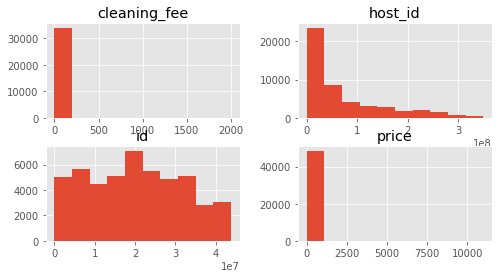

In [16]:
# first look into the data
type(ab_clean.hist(figsize=(8,4)))

In [17]:
ab_clean.describe()
# price and cleaning fee quite right skewed, irrelevant statistics for host_id and id

,id,host_id,price,cleaning_fee
count,4.862100e+04,4.862100e+04,48621.000000,34053.000000
mean,2.017842e+07,7.085350e+07,91.832192,27.857869
std,1.171403e+07,8.055496e+07,229.266883,31.446221
min,1.944000e+03,1.581000e+03,0.000000,0.000000
25%,9.987404e+06,1.048923e+07,40.000000,10.000000
50%,2.023167e+07,3.739402e+07,65.000000,20.000000
75%,2.957905e+07,1.072654e+08,104.000000,40.000000
max,4.376487e+07,3.496313e+08,11000.000000,2000.000000


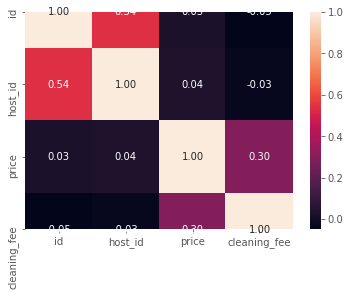

In [18]:
sb.heatmap(ab_clean.corr(), annot = True, fmt = '.2f');
# price and cleaning fee have some correlation
# and with id and host_id as expected around 0 correlation

### identify duplicates

In [19]:
ab19_rev.head(2)

,listing_id,id,date,reviewer_id,reviewer_name,comments
0,1944,7126992,2013-09-07,8207524,Mirko,I want to thank Laura&Emiliano for their hospi...
1,1944,7428447,2013-09-19,3021574,Rafiee,Very convenient and very quiet. You will stay...


In [20]:
print('for 2019 scraped reviews: \n')
print('column listing_id is unique?: ', ab19_rev.listing_id.duplicated().sum() == 0)
print('column id is unique?: ', ab19_rev.id.duplicated().sum() == 0)

print('\n for 2020 scraped reviews: \n')
print('column listing_id is unique?: ', ab20_rev.listing_id.duplicated().sum() == 0)
print('column id is unique?: ', ab20_rev.id.duplicated().sum() == 0)

for 2019 scraped reviews: 

column listing_id is unique?:  False
column id is unique?:  True

 for 2020 scraped reviews: 

column listing_id is unique?:  False
column id is unique?:  True


__define__: set the 'id' column as index as it is numeric and has no duplicates

In [21]:
# Code:
ab19_rev = ab19_rev.set_index('id')
ab20_rev = ab20_rev.set_index('id')
# Test:
ab19_rev.head(1)

,listing_id,date,reviewer_id,reviewer_name,comments
id,,,,,
7126992,1944,2013-09-07,8207524,Mirko,I want to thank Laura&Emiliano for their hospi...


### Missing values
Looking at all columns of interest.

In [22]:
ab_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 48621 entries, 0 to 24812
Data columns (total 10 columns):
id                              48621 non-null int64
host_id                         48621 non-null int64
host_neighbourhood              37396 non-null object
neighbourhood_group_cleansed    48621 non-null object
last_review                     39718 non-null object
price                           48621 non-null float64
cleaning_fee                    34053 non-null float64
cancellation_policy             48621 non-null object
host_since                      48530 non-null object
last_scraped                    48621 non-null object
dtypes: float64(2), int64(2), object(6)
memory usage: 4.1+ MB


#### missings in last review
##### Define:
There are missing values in 'last_review': offers without reviews are reasonable. Let's gain some confidence: I expect newer offers to have more missing reviews.

I cannot identify a column with "AirBnb offer since" information, hence using as proxy 'host_since'. It's not optimal because a host can have multiple offers.

##### Code:

In [23]:
df1 = pd.concat([ab_clean.last_review.str[0:4], ab_clean.host_since.str[0:4]], axis = 1)
print('mean host_since year for offers with review: \n',  
      df1[~df1.last_review.isna()].host_since.astype(float).mean())
print('mean host_since year for offers without review: \n',  
      df1[df1.last_review.isna()].host_since.astype(float).mean())

mean host_since year for offers with review: 
 2014.904563792234
mean host_since year for offers without review: 
 2015.4599774520857


##### Evaluate:
Yes, missing reviews and newer host_since go hand in hand.

We find no evidence that missing reviews have and explanation different to no review yet.

### Neighbourhood
define: due to missings in 'host_neighbourhood' we use only the column 'neighbourhood_group_cleansed'.

In [24]:
# code:
tmp = ab_clean.shape[1]
ab_clean = ab_clean.drop(columns = ['host_neighbourhood'])
# test:
print('down', tmp - ab_clean.shape[1], 'column as expected')

down 1 column as expected


### Last review data type
__define__: convert 'last_review' to a format which allows calculations on time

In [25]:
# Code
# inspired by https://stackoverflow.com/questions/45100262/typeerror-strptime-argument-1-must-be-string-not-float
ab_clean['last_review'] = pd.to_datetime(ab_clean.last_review)
# Test:
ab_clean.last_review.dtypes

dtype('<M8[ns]')

### Scrape day
__define__: save the days the data was scraped from Airbnb in datetime format

In [26]:
# Code:
ab19_scrape_day = pd.to_datetime('2019-06-08')
ab20_scrape_day = pd.to_datetime('2020-06-13')
# Test:
type(ab19_scrape_day), type(ab20_scrape_day)

(pandas._libs.tslibs.timestamps.Timestamp,
 pandas._libs.tslibs.timestamps.Timestamp)

### Scrape year
__define__: create a column to identify the year the data was collected

In [27]:
# code:
ab_clean['last_scraped_year'] = ab_clean.last_scraped.apply(lambda x: x[0:4])
# test:
ab_clean.last_scraped_year.value_counts()

2020    24813
2019    23808
Name: last_scraped_year, dtype: int64

### Assess and Clean for "Detailed Review Data" data

In [28]:
ab19_rev.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 467550 entries, 7126992 to 465199123
Data columns (total 5 columns):
listing_id       467550 non-null int64
date             467550 non-null object
reviewer_id      467550 non-null int64
reviewer_name    467550 non-null object
comments         467335 non-null object
dtypes: int64(2), object(3)
memory usage: 21.4+ MB


In [29]:
ab20_rev.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 516939 entries, 69544350 to 629450769
Data columns (total 5 columns):
listing_id       516939 non-null int64
date             516939 non-null object
reviewer_id      516939 non-null int64
reviewer_name    516939 non-null object
comments         516612 non-null object
dtypes: int64(2), object(3)
memory usage: 23.7+ MB


In [30]:
print('no issue with missing values in review data: no missings, and irrelevant number of missings respectively in reviews itself -> share of missings: ', 
        (ab19_rev.comments.isnull().sum() / ab19_rev.shape[0]), '(2019), and',
        ab20_rev.comments.isnull().sum() / ab20_rev.shape[0], '(2020)')

no issue with missing values in review data: no missings, and irrelevant number of missings respectively in reviews itself -> share of missings:  0.00045984386696609986 (2019), and 0.0006325698003052584 (2020)


### limit to time frame of interest: Number of reviews in 2020, as available yet, and same period in 2019
__define__: We're looking at complete months. Hence we start to have stays under the Corona influence from April 2020 as the awareness of Corona came Mid-March 2020 in the area. The data provides complete months till May 2020. So we use April and May 2020 and compare the reviews to the months one year before circumventing seasonality in the data.

The 2020 scrape day 13 June allowed also guests since 31 May 2020 to give their review and is thus not considered as a bias: after 14 days it's not possible to write a review ([source](https://www.airbnb.com/help/article/995/how-long-do-i-have-to-write-a-review-after-a-trip-has-ended)).

In [31]:
# Code:
ab19_rev = ab19_rev.query("date > '2019-04-01' and date < '2019-05-31'")
ab20_rev = ab20_rev.query("date > '2020-04-01' and date < '2020-05-31'")
number_rev19_corona_period = ab19_rev.count().listing_id
number_rev20_corona_period = ab20_rev.count().listing_id

In [32]:
# Test:
print('the number of reviews % change April-May 2019 to 2020 is ', 
        (number_rev20_corona_period / number_rev19_corona_period) - 1,
      '\n \n and in absolute values for 2019:', number_rev19_corona_period, 'and for 2020:', number_rev20_corona_period
     )

the number of reviews % change April-May 2019 to 2020 is  -0.9359379943055995 
 
 and in absolute values for 2019: 37932 and for 2020: 2430


### handling missings in reviews

In [33]:
ab19_rev.comments.isnull().sum(), ab20_rev.comments.isnull().sum()

(30, 11)

__define__: the number of NaN reviews is 41 out of about 40,000, i.e. the rows are irrelevent hence we just drop the rows.

In [34]:
# code:
ab19_rev = ab19_rev[~(ab19_rev.comments.isna())]
ab20_rev = ab20_rev[~(ab20_rev.comments.isna())]
# test:
print('after removing NA comments we have', ab19_rev.shape[0], 'and', \
      ab20_rev.shape[0], 'lines left')

after removing NA comments we have 37902 and 2419 lines left


<a id='eda'></a>
# Analyze, Model, and Visualize

<a id='impact_demand'></a>
## Corona impact on Airbnb demand

Evaluating days since last review

#### overall for the years

In [35]:
last_review19 = (ab19_scrape_day - ab_clean[ab_clean.last_scraped_year == '2019']\
                 .last_review).median().days
last_review20 = (ab20_scrape_day - ab_clean[ab_clean.last_scraped_year == '2020'].\
                 last_review).median().days
print('median days since last review is', last_review19, '(2019), and', last_review20, '(2020), i.e. a % change of', 
      (last_review20 / last_review19) - 1)

median days since last review is 114 (2019), and 241 (2020), i.e. a % change of 1.1140350877192984


#### by neighborhood for the years

In [36]:
def diff_to_scrape_day(data, year, scrape_day):
    '''
    INPUT:
    data - a dataframe holding the Airbnb data with neighbourhood_group_cleansed, last_review
    year - a string with 2019 or 2020
    scrape_day - dataset scrape day in datetime format

    OUTPUT:
    X - dataframe with median day difference between scrape day and review per neighbourhood
    '''
    mean_diff_nbh = []
    for nbh in np.unique(data.neighbourhood_group_cleansed):
        mean_diff_nbh.append((
            nbh,
            year,
            (
            (scrape_day 
             - data[data.neighbourhood_group_cleansed == nbh].last_review).median()
            ).days
        ))
    df = pd.DataFrame(mean_diff_nbh)
    df.columns = ['neighbourhood', 'year', 'days_since_last_review']
    return df

In [37]:
diff19 = diff_to_scrape_day(ab_clean[ab_clean.last_scraped_year == '2019'], '2019', ab19_scrape_day)
diff20 = diff_to_scrape_day(ab_clean[ab_clean.last_scraped_year == '2020'], '2020', ab20_scrape_day)

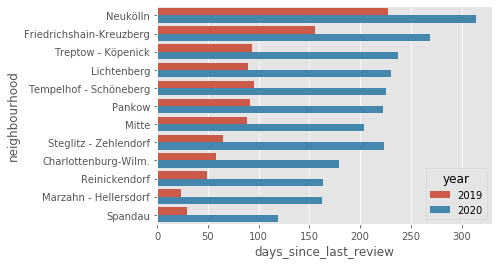

In [38]:
# compare _absolute_ values of median difference in days since last review
# sorted by highest value over years per neighbourhood
df1 = pd.concat([diff19, diff20])
sort_df = df1.groupby(df1.neighbourhood).sum().\
            sort_values('days_since_last_review', ascending = False).index
sb.barplot(y='neighbourhood', x='days_since_last_review', data=df1, hue='year', order=sort_df);

In [39]:
# compare _difference_ in values of median difference in days since last review
df1 = pd.merge(left=diff19, right=diff20, on='neighbourhood')
df1['last_review_diff'] = df1.days_since_last_review_y - df1.days_since_last_review_x

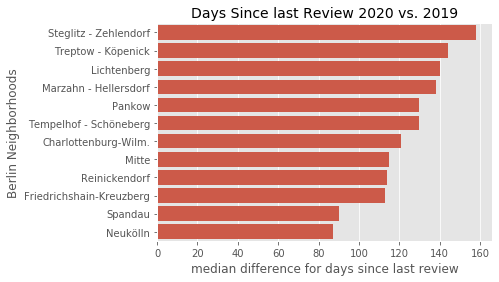

In [40]:
sort_df = df1.sort_values(by='last_review_diff', ascending = False).neighbourhood
base_color = sb.color_palette()[0]
ax = sb.barplot(y='neighbourhood', x='last_review_diff', data=df1, 
                order=sort_df, color=base_color)
ax.set_title('Days Since last Review 2020 vs. 2019', fontsize=14)
plt.xlabel('median difference for days since last review')
plt.ylabel('Berlin Neighborhoods');

<a id='host_reaction'></a>
## Host Reaction
Looking at number of offers, price, and cancellation policy
### Number of offers

In [41]:
# overall the number of flats offered increased by 4%
print((24813 / 23808) - 1)
ab_clean.last_scraped_year.value_counts()

0.04221270161290325


2020    24813
2019    23808
Name: last_scraped_year, dtype: int64

In [42]:
df1 = pd.DataFrame(ab_clean.groupby(ab_clean.neighbourhood_group_cleansed).\
        last_scraped_year.value_counts().sort_index())
df1 = pd.DataFrame((df1.last_scraped_year.unstack()['2020'] / df1.last_scraped_year.unstack()['2019'] \
         - 1).sort_values(ascending=False))
df1.columns = ['change_flats_offered']
df1 = df1.reset_index()

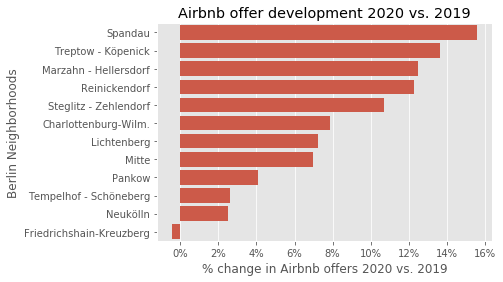

In [43]:
ax = sb.barplot(y='neighbourhood_group_cleansed', x='change_flats_offered', data=df1, color=base_color);
plt.title('Airbnb offer development 2020 vs. 2019')
plt.xlabel('% change in Airbnb offers 2020 vs. 2019')
plt.ylabel('Berlin Neighborhoods')

# x-axis in percentage, inspired by https://stackoverflow.com/questions/31357611/format-y-axis-as-percent#31357733:
vals = ax.get_xticks()
ax.set_xticklabels(['{:,.0%}'.format(x) for x in vals]);

### Price
for right skewed price look at median as it is immune to outliers

In [44]:
tmp = ab_clean.price.groupby(ab_clean.last_scraped_year)
#tmp.mean()
print((tmp.median()['2020'] / tmp.median()['2019']) - 1)
tmp.median()

0.048387096774193505


last_scraped_year
2019    62.0
2020    65.0
Name: price, dtype: float64

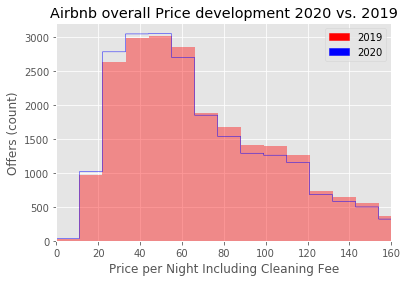

In [45]:
# Histogram for Prices in 2019 and 2020
# shows price shift to the right
ab_clean[ab_clean.last_scraped_year=='2020'].price.hist(bins=1000, alpha=.4, color='red');
ab_clean[ab_clean.last_scraped_year=='2019'].price.hist(bins=1000, alpha=.9, color='blue', histtype='step');
plt.title('Airbnb overall Price development 2020 vs. 2019')
plt.xlabel("Price per Night Including Cleaning Fee")
plt.ylabel("Offers (count)");

# custom labels inspired by https://stackoverflow.com/questions/39500265/manually-add-legend-items-python-matplotlib#39500357
red_patch = mpatches.Patch(color='red', label='2019')
blue_patch = mpatches.Patch(color='blue', label='2020')
plt.legend(handles=[red_patch, blue_patch])
plt.xlim(0,160);

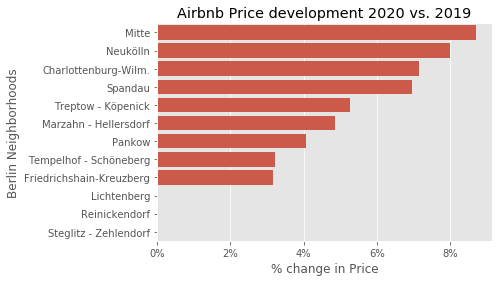

In [46]:
df1 = ab_clean.groupby(['neighbourhood_group_cleansed', 'last_scraped_year']).price.median().unstack()
df1 = pd.DataFrame((df1['2020'] / df1['2019']) - 1)
df1.columns = ['price_difference']
df1 = df1.reset_index().sort_values(by='price_difference', ascending = False)

ax = sb.barplot(y='neighbourhood_group_cleansed', x='price_difference', data=df1, color=base_color);
plt.title('Airbnb Price development 2020 vs. 2019')
plt.xlabel('% change in Price')
plt.ylabel('Berlin Neighborhoods')

# x-axis in percentage, inspired by https://stackoverflow.com/questions/31357611/format-y-axis-as-percent#31357733:
vals = ax.get_xticks()
ax.set_xticklabels(['{:,.0%}'.format(x) for x in vals]);

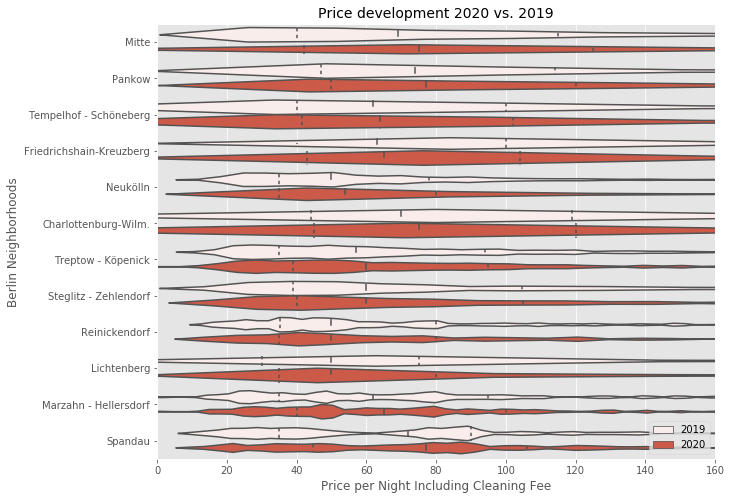

In [47]:
plt.figure(figsize=(10, 8))
ax = sb.violinplot(y='neighbourhood_group_cleansed', x='price', hue='last_scraped_year',
              data=ab_clean,
             color = base_color, inner = 'quartile', bw=.04)
ax.set_title('Price development 2020 vs. 2019', fontsize=14)
ax.legend(loc='lower right')
plt.xlabel('Price per Night Including Cleaning Fee')
plt.ylabel('Berlin Neighborhoods')
plt.xlim(0,160);

### Cancellation Policy

In [48]:
# number of flats with "partly refund only when canceled at least 30 days before": down a lot;
# more flexible around 10%

# details from Airbnb on policy:
# https://www.airbnb.de/home/cancellation_policies#super-strict-30
# https://www.airbnb.de/home/cancellation_policies#super-strict-60

df2 = pd.DataFrame(ab_clean.groupby(ab_clean.last_scraped_year).\
                   cancellation_policy.value_counts())
df2 = df2.cancellation_policy.unstack(level = 'last_scraped_year')
df2 = pd.DataFrame((df2['2020'] / df2['2019']) - 1)
df2.columns = ['cancellation_policy_change']
df2 = df2.reset_index().sort_values(by='cancellation_policy_change', ascending = False)
df2 = df2.drop(index=2) # strict only 2 in both years -> ignore
df2

,cancellation_policy,cancellation_policy_change
5,super_strict_60,0.725000
0,flexible,0.074431
3,strict_14_with_grace_period,0.029555
1,moderate,0.016873
4,super_strict_30,-0.790323


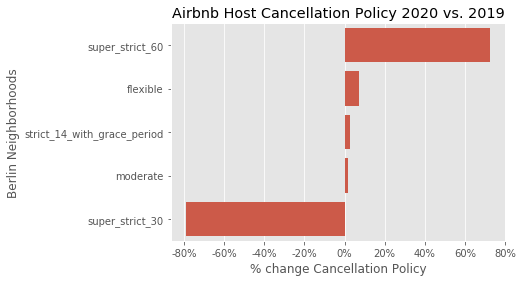

In [49]:
ax = sb.barplot(y='cancellation_policy', x='cancellation_policy_change', data=df2, color=base_color);
plt.title('Airbnb Host Cancellation Policy 2020 vs. 2019')
plt.xlabel('% change Cancellation Policy')
plt.ylabel('Berlin Neighborhoods')

# x-axis in percentage, inspired by https://stackoverflow.com/questions/31357611/format-y-axis-as-percent#31357733:
vals = ax.get_xticks()
ax.set_xticklabels(['{:,.0%}'.format(x) for x in vals]);

<a id='happy'></a>
## Happyness of Travelers
Sentiment Analysis

Here we use the "Detailed Review Data" from Murray Cox. In the analysis above we had 2 points in time, i.e. to scrape days. However, the reviews have a timestamp.

In [50]:
print('the scrape days of the data were for 2019:', ab19_scrape_day, 'and for 2020:', ab20_scrape_day)

the scrape days of the data were for 2019: 2019-06-08 00:00:00 and for 2020: 2020-06-13 00:00:00


In [51]:
ab19_rev.shape, ab20_rev.shape

((37902, 5), (2419, 5))

In [52]:
print('% change of', (ab20_rev.shape[0] / ab19_rev.shape[0]) - 1)

% change of -0.9361775104216137


In [53]:
df4 = pd.DataFrame({ 'year': ['April/May 2019', 'April/May 2020'], 
                   'reviews': [ab19_rev.shape[0], ab20_rev.shape[0]] })

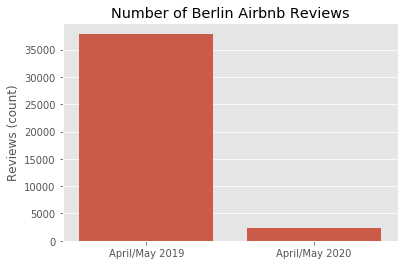

In [54]:
ax = sb.barplot(y='reviews', x='year', data=df4, color=base_color);
plt.title('Number of Berlin Airbnb Reviews')
plt.xlabel('')
plt.ylabel('Reviews (count)');

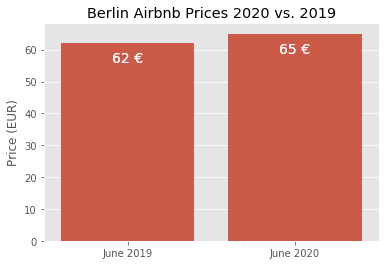

In [55]:
tmp = ab_clean.price.groupby(ab_clean.last_scraped_year)
df = pd.DataFrame({ 'year': ['June 2019', 'June 2020'], 
                   'prices': [tmp.median()['2019'], tmp.median()['2020']] })
ax = sb.barplot(y='prices', x='year', data=df, color=base_color);
plt.title('Berlin Airbnb Prices 2020 vs. 2019')
plt.xlabel('')
plt.ylabel('Price (EUR)')

# value shown on bar inspired by https://stackoverflow.com/questions/39519609/annotate-bars-with-values-on-pandas-on-seaborn-factorplot-bar-plot#39798852
def annotateBars(row, ax=ax): 
    for p in ax.patches:
        ax.annotate("%.0f €" % p.get_height(), (p.get_x() + p.get_width() / 2., p.get_height()),
             ha='center', va='center', fontsize=14, color='white', rotation=0, xytext=(0, -15),
             textcoords='offset points')
plot = df.apply(annotateBars, ax=ax, axis=1)

In [56]:
ab19_rev.head(2)

,listing_id,date,reviewer_id,reviewer_name,comments
id,,,,,
434592346,2015,2019-04-08,56639578,Jane,Great location within walking distance of the ...
440838489,2695,2019-04-21,14703261,Alessandra,Michael is kind host and our stay was very ple...


### find sentiment for April to May in 2019 vs. 2020
We look at the reviews in April and May 2020 and the same months one year before. Please refer to the discussion above under "assess and clean" with the headline "limit to time frame of interest: Number of reviews in 2020, as available yet, and same period in 2019".

In [57]:
# inspired by https://medium.com/@b.terryjack/nlp-pre-trained-sentiment-analysis-1eb52a9d742c
sid = SentimentIntensityAnalyzer()

ab20_rev_senti = ab20_rev['comments'].apply(sid.polarity_scores)

In [58]:
ab20_rev_senti.head(2)

id
621648857    {'neg': 0.0, 'neu': 0.441, 'pos': 0.559, 'comp...
626407441    {'neg': 0.0, 'neu': 0.668, 'pos': 0.332, 'comp...
Name: comments, dtype: object

#### Filter non-English comments
The text analysis is optimized for English language. One might try to translate all reviews to English first or to identify the language and apply sentiment analysis suited for multiple languages.

What we do here: try to filter out reviews which cannot be interpreted well by the algorithm.

To filter English: we observe that the English optimized sentiment analysis yields a high __share of neutral words__ for a review when the review is not in English.

##### Limiting the neutral word share to below 95%
We find for the filtered reviews that in the sample below 9 out of 10 reviews are in fact in English.<br>
$\rightarrow$ this is reassuring and we continue

In [59]:
tmp = ab20_rev[ab20_rev_senti.apply(lambda x: x['neu']) < .95]
print('Limiting the neutral word share to below 95% we lose', ab20_rev.shape[0] - tmp.shape[0], 'of', ab20_rev.shape[0], 'observations i.e. use', tmp.shape[0], 'observations.')
tmp.comments[0:10]

Limiting the neutral word share to below 95% we lose 542 of 2419 observations i.e. use 1877 observations.


id
621648857               Amazing hospitality and communication.
626407441    The place is in an exceptional location, it is...
623637430    Awesome place in a great neighborhood! I reall...
623401243    Excellent location close to everything you cou...
622509987    The apartment is very well located, very close...
626097967    Bernd and Katja are amazing hosts. The communi...
625478639                 Everything was TIP TOP! Case closed!
626748481    We had an amazing  2 weeks in Berlin and in th...
622565885    88 Treppenstufen, die sich lohnen! Carol hat e...
625887286    Great Location, really clean and Good Communic...
Name: comments, dtype: object

Another point for this approach: There are reviews which are not in English and are not identified by the neutral word share -- however, the words are correctly analyzed in terms of sentiment.

Example: the German comment below contains "super", is positive and is identified as positive by the algorithm.

In [60]:
ab20_rev.loc[623416557].comments

'Alles super. :-)'

In [61]:
ab20_rev_senti[623416557]

{'neg': 0.0, 'neu': 0.139, 'pos': 0.861, 'compound': 0.7351}

##### compound value 
The compound value gives the sentiment of the review. A compound value of \>0.05 can be seen as positive, source: https://github.com/cjhutto/vaderSentiment#about-the-scoring

In [62]:
# share of positive reviews
df = ab20_rev[(ab20_rev_senti.apply(lambda x: (x['neu']) < .95 and x['compound']) > 0.05)]
print(df.shape[0], 'from', tmp.shape[0], 'observations these are identified as positive')

1218 from 1877 observations these are identified as positive


In [63]:
# Test: -> filtered as expected
# ab20_rev_senti.loc[df.index].apply(lambda x: x['neu'])
# ab20_rev_senti.loc[df.index].apply(lambda x: x['compound'])

In [64]:
# write a function to evaluate programmatically
def sentiment_share(df):
    '''
    The function applies sentiment analysis on comments with netral <.95 and compound >.05.
    Requirements: Initialized sid = SentimentIntensityAnalyzer().
    
    INPUT:
    df = data frame with reviews in column 'comments'
    OUTPUT:
    number of positive reviews, number of evaluated reviews
    '''
    df_senti = df['comments'].apply(sid.polarity_scores)
    relevant = df[df_senti.apply(lambda x: x['neu']) < .95]
    relevant_pos = df[(df_senti.apply(lambda x: (x['neu']) < .95 and x['compound']) > 0.05)]
    return relevant_pos.shape[0], relevant.shape[0]

In [65]:
# share of positive reviews in April to May 2019
res = sentiment_share(ab19_rev)
rev_pos19 = res[0] / res[1]

In [66]:
# share of positive reviews in April to May 2020
res = sentiment_share(ab20_rev)
rev_pos20 = res[0] / res[1]

In [67]:
print('share of positive reviews is', rev_pos19, '(2019), and', rev_pos20, '(2020), i.e. a % change of', 
     (rev_pos20 / rev_pos19) - 1)

share of positive reviews is 0.8482754207461445 (2019), and 0.648907831646244 (2020), i.e. a % change of -0.23502695495354142


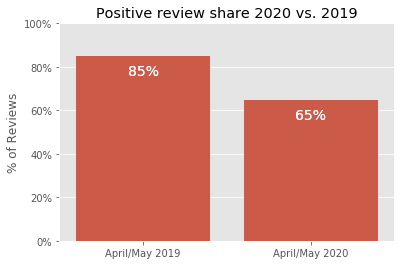

In [68]:
df = pd.DataFrame({'year': ['April/May 2019', 'April/May 2020'], 
                   'values_': [rev_pos19, rev_pos20]})

ax = sb.barplot(y='values_', x='year', data=df, color=base_color);
plt.title('Positive review share 2020 vs. 2019')
plt.xlabel('')
plt.ylabel('% of Reviews')
plt.ylim(0,1)
vals = ax.get_yticks()
ax.set_yticklabels(['{:,.0%}'.format(x) for x in vals]);
def annotateBars(row, ax=ax): 
    for p in ax.patches:
        ax.annotate('{:.0f}%'.format(100 * p.get_height()), (p.get_x() + p.get_width() / 2., p.get_height()),
             ha='center', va='center', fontsize=14, color='white', rotation=0, xytext=(0, -15),
             textcoords='offset points')
plot = df.apply(annotateBars, ax=ax, axis=1)